In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from datetime import timedelta
%matplotlib inline

In [2]:
world_poppercap = 7700000000 / 1000000
us_poppercap = 329877505 / 1000000
la_poppercap = 4648794 / 1000000

ticks = 10  #number of X ticks


In [3]:
def weekofyear(date):
    """
    Convert date to week of year for plotting weekly data
    Intended use for pandas.dataframe.map
    Need to be done before dropping yeah from date
    """
    dt = datetime.strptime(date, '%Y-%m-%d')
    return int(dt.strftime('%U'))


def rollingavg(y, days = 7):
    y = np.array(y)
    
    output = np.zeros((y.shape[0] * days), dtype=np.float64).reshape((y.shape[0],days))
        
    for idx in range(7,y.shape[0]):
        output[idx] = y[idx-7:idx]
    
    return np.mean(output,axis=1)
    
def newstats(df):
    """
        Changes daily totals to new cases and new deaths and adds them to dateframe
    """
    #changing daily totals to new cases
    newcases = np.zeros(df.shape[0], dtype=np.int32)
    newdeaths = np.zeros(df.shape[0], dtype=np.int32)
    deathscolumn = df.columns.get_loc('deaths')
    casescolumn = df.columns.get_loc('cases')

    newcases[0] = df.iloc[0,casescolumn]
    newdeaths[0] = df.iloc[0,deathscolumn]


    for idx in df.index[1:]:
        newcases[idx] = df.iloc[idx,casescolumn] - df.iloc[idx-1,casescolumn]
        newdeaths[idx] = df.iloc[idx,deathscolumn] - df.iloc[idx-1,deathscolumn]

    df['NewCases'] = newcases
    df['NewDeaths'] = newdeaths
    df['NewCasesRollAvg'] = rollingavg(newcases)
    df['NewDeathsRollAvg'] = rollingavg(newdeaths)

def drawindexofCDCdataloss(df,ax, color="magenta", label="CDC Loses Ctrl"):
    """
        Draws a line at the date where CDC took control of data
        
        Reference:  https://www.nytimes.com/2020/07/14/us/politics/trump-cdc-coronavirus.html
    """
    JudgementDate = '04-05'
    ax.axvline(df[df['date']==JudgementDate].index.values[0],ymin=0, ymax=1,label=label, color=color,zorder=-100)
    
def getyTicks(df, columns, yticks=8):
    """
        Gets yTicks and returns labels
    """
    dfmax = np.max(df[columns])
    items_per_tick = dfmax / yticks
    out_yticks = np.arange(0,dfmax,items_per_tick)
    #axs[0].set_yticks(la_yticks)
    out_ticklabels = []
    for i in out_yticks:
        if i > 1000000:
            out_ticklabels.append("{0:,.3g}M".format(i/1000000.))
        elif i > 10000:
            out_ticklabels.append("{0:,.3g}K".format(i/1000.0))
        else:
            out_ticklabels.append("{0:,.0f}".format(i))

    return (out_yticks, out_ticklabels)
    
#This is to mark the dataset problem mentioned above

def LACFline(df,ax):
    """
        Adds a line for data adjustment to LA data on 6/19 mentioned above.  nytimes issues 377
    """
    
    idx = df[df['date']=='06-19'].index.values[0]
    line = ax.axvline(idx,ymin=0,ymax=1,color='r',label="LA Data Adjust", zorder=-100)
    
    return line

def holidays(df,ax):
    """
        Adds lines for major holiday
        
    """
    holidays_list = [
        ('03-25','Memorial Day'),
        ('07-04', '4th of July'),
        ('04-12','Easter'),
        ('09-07','Labor Day')
    ]
    
    label = "Holiday"
    for h in holidays_list:
        line = ax.axvline(df[df['date']==h[0]].index.values[0],ymin=0,ymax=1,color='pink',label=label, zorder=-100)
        label = None
    
    return line
    


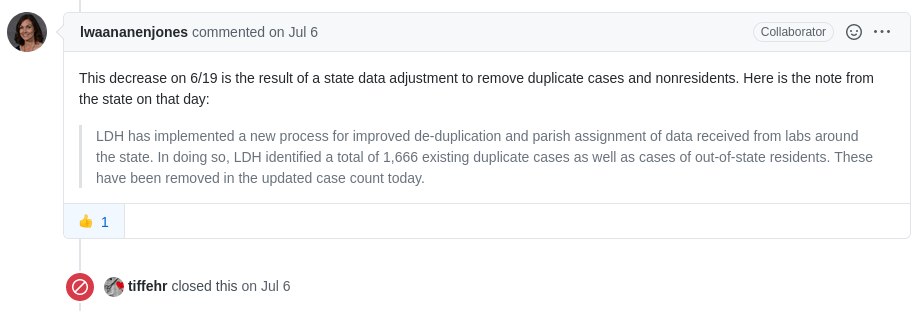

There was an issue with one of the days in louisiana which caused a negative result in the newcases for 6/19

https://github.com/nytimes/covid-19-data/issues/377

In [4]:
#state_df = pd.read_csv('./us-states.csv')
state_df = pd.read_csv('./covid-19-data/us-states.csv')  #moved nytimes data to submodule

la_df = state_df[state_df['state'] == 'Louisiana']
la_df = la_df.sort_values(['date'], ascending=True)

#week of year
la_df['week'] = la_df['date'].map(weekofyear)  #maybe this will be used again later


#shorten date
la_df['date'] = la_df['date'].map(lambda x: x[5:])

la_df['cases_ravg'] = rollingavg(la_df['cases'])
la_df['deaths_ravg'] = rollingavg(la_df['deaths'])

la_df.index = np.arange(la_df.shape[0])
newstats(la_df)

la_df['NewCasesPerCapita'] = la_df['NewCases'] / la_poppercap
la_df['NewDeathsPerCapita'] = la_df['NewDeaths'] / la_poppercap

la_df['NewCasesPerCapita_ravg'] = rollingavg(la_df['NewCasesPerCapita'])
la_df['NewDeathsPerCapita_ravg'] = rollingavg(la_df['NewDeathsPerCapita'])

la_items_pertick = la_df.shape[0] / ticks
la_ticks = np.append(np.arange(0,la_df.shape[0], la_items_pertick), [la_df.shape[0]-1])
la_items_pertick += 1

la_df.tail(2)


,date,state,fips,cases,deaths,week,cases_ravg,deaths_ravg,NewCases,NewDeaths,NewCasesRollAvg,NewDeathsRollAvg,NewCasesPerCapita,NewDeathsPerCapita,NewCasesPerCapita_ravg,NewDeathsPerCapita_ravg
199,09-24,Louisiana,22,164446,5423,38,162124.000000,5360.714286,577,16,572.000000,16.142857,124.118212,3.441753,123.042664,3.472483
200,09-25,Louisiana,22,165152,5444,38,162710.142857,5376.714286,706,21,586.142857,16.000000,151.867345,4.517301,126.084928,3.441753


In [5]:
#us_df = pd.read_csv('./us.csv')
us_df = pd.read_csv('./covid-19-data/us.csv')  #movied nytimes/covid-19-data to submodule
us_df = us_df.sort_values('date')
us_df[us_df['date'] == '2020-03-09']

#slice to match up with Louisiana data for better comparison
us_df = us_df.iloc[48:,:]

#week of year
us_df['week'] = us_df['date'].map(weekofyear)  #maybe this will be used again later

#shorten date
us_df['date'] = us_df['date'].map(lambda x: x[5:])

us_df['cases_ravg'] = rollingavg(us_df['cases'])
us_df['deaths_ravg'] = rollingavg(us_df['deaths'])

us_df.index = np.arange(us_df.shape[0])
newstats(us_df)

us_df['NewCasesPerCapita'] = us_df['NewCases'] / us_poppercap
us_df['NewDeathsPerCapita'] = us_df['NewDeaths'] / us_poppercap

us_df['NewCasesPerCapita_ravg'] = rollingavg(us_df['NewCasesPerCapita'])
us_df['NewDeathsPerCapita_ravg'] = rollingavg(us_df['NewDeathsPerCapita'])

us_items_pertick = us_df.shape[0] / ticks
us_ticks = np.append(np.arange(0,us_df.shape[0], us_items_pertick),[us_df.shape[0]-1])
us_items_pertick += 1


us_df.tail(2)


,date,cases,deaths,week,cases_ravg,deaths_ravg,NewCases,NewDeaths,NewCasesRollAvg,NewDeathsRollAvg,NewCasesPerCapita,NewDeathsPerCapita,NewCasesPerCapita_ravg,NewDeathsPerCapita_ravg
199,09-24,7004672,202707,38,6.831334e+06,199550.857143,45178,885,43738.000000,734.571429,136.953867,2.682814,132.588610,2.226801
200,09-25,7059208,203571,38,6.875052e+06,200290.571429,54536,864,43718.714286,739.714286,165.321973,2.619154,132.530147,2.242391


In [6]:
columns = ['date','new_cases','new_deaths','total_cases','total_deaths']
newcolumns = ['date','NewCases','NewDeaths','cases','deaths']  #set the columns to match the other dataframes

world_df = pd.read_csv('./owid-coviddata/public/data/owid-covid-data.csv')
world_df = world_df[world_df['iso_code'] == 'OWID_WRL'][columns]
world_df.columns = newcolumns

world_df = world_df.sort_values('date')
world_df.index = np.arange(world_df.shape[0])
world_df = world_df.iloc[world_df.index[world_df['date'] == '2020-03-09'][0]:,:]

world_df['week'] = world_df['date'].map(weekofyear)
world_df['date'] = world_df['date'].map(lambda x: x[5:])

world_df['NewCasesRollAvg'] = rollingavg(world_df['NewCases'])
world_df['NewDeathsRollAvg'] = rollingavg(world_df['NewDeaths'])

world_df['cases_ravg'] = rollingavg(world_df['cases'])
world_df['deaths_ravg'] = rollingavg(world_df['deaths'])

world_df.index = np.arange(world_df.shape[0])

world_df['NewCasesPerCapita'] = world_df['NewCases'] / world_poppercap
world_df['NewDeathsPerCapita'] = world_df['NewDeaths'] / world_poppercap

world_df['NewCasesPerCapita_ravg'] = rollingavg(world_df['NewCasesPerCapita'])
world_df['NewDeathsPerCapita_ravg'] = rollingavg(world_df['NewDeathsPerCapita'])

world_items_pertick = world_df.shape[0] / ticks
world_items_per_tick = world_df.shape[0] / ticks
world_ticks = np.append(np.arange(0,world_df.shape[0], world_items_pertick),[world_df.shape[0]-1])


world_df.tail(2)

,date,NewCases,NewDeaths,cases,deaths,week,NewCasesRollAvg,NewDeathsRollAvg,cases_ravg,deaths_ravg,NewCasesPerCapita,NewDeathsPerCapita,NewCasesPerCapita_ravg,NewDeathsPerCapita_ravg
200,09-25,319628.0,5783.0,32303755.0,984160.0,38,295084.857143,5273.285714,3.111417e+07,962173.142857,41.510130,0.751039,38.322709,0.684842
201,09-26,310089.0,5568.0,32613844.0,989728.0,38,295701.714286,5339.428571,3.140988e+07,967512.571429,40.271299,0.723117,38.402820,0.693432


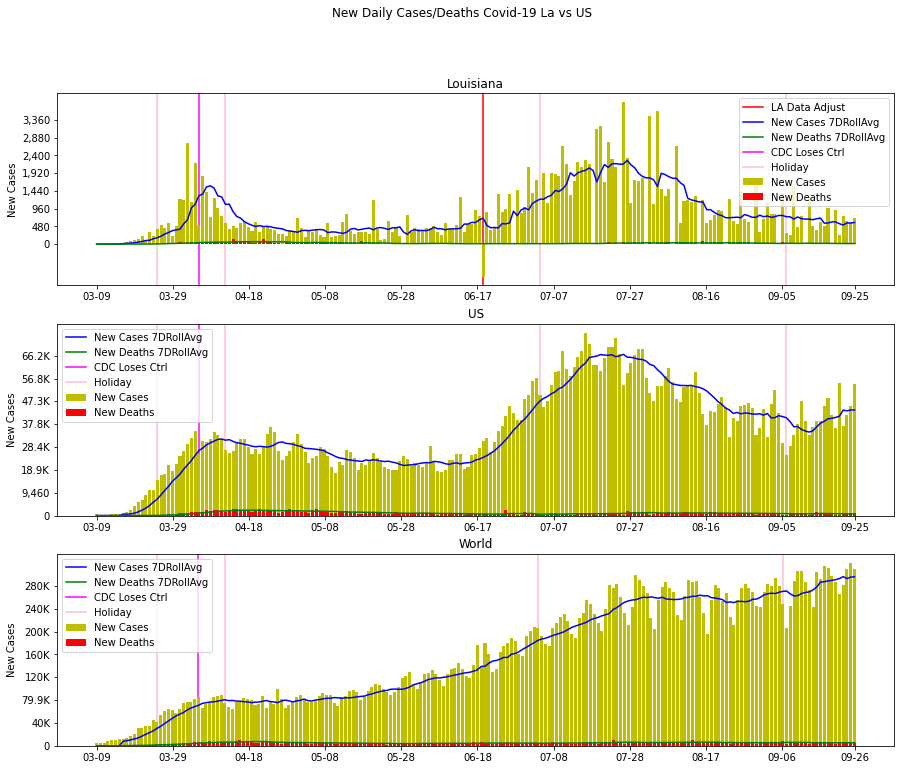

In [7]:
#Figure 1
fig, axs = plt.subplots(3, figsize=(15,12))

def plotme(df, ax,xticks):
    


    ax.bar(df.index,df['NewCases'], color='y', label='New Cases')
    ax.bar(df.index,df['NewDeaths'], color='r', label='New Deaths')
    ax.plot(df.index,df['NewCasesRollAvg'], color = 'b',label='New Cases 7DRollAvg')
    ax.plot(df.index,df['NewDeathsRollAvg'], color = 'g', label='New Deaths 7DRollAvg')
    ax.set_xticks(xticks)
    ax.set_xticklabels(df.iloc[xticks,0])
    drawindexofCDCdataloss(df,ax)
    holidays(df,ax)
    ax.legend()
    
    yticks,yticklabels = getyTicks(df,'NewCases')
    ax.set_yticks(yticks)        
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel("New Cases")
    

axs[0].title.set_text('Louisiana')

#adjustments for LA data issue 4/19
LACFline(la_df,axs[0])

plotme(la_df,axs[0],la_ticks)

axs[1].title.set_text('US')
plotme(us_df,axs[1],us_ticks)

axs[2].title.set_text('World')
plotme(world_df,axs[2],world_ticks)

fig.suptitle("New Daily Cases/Deaths Covid-19 La vs US")

plt.savefig("fig1.jpg")


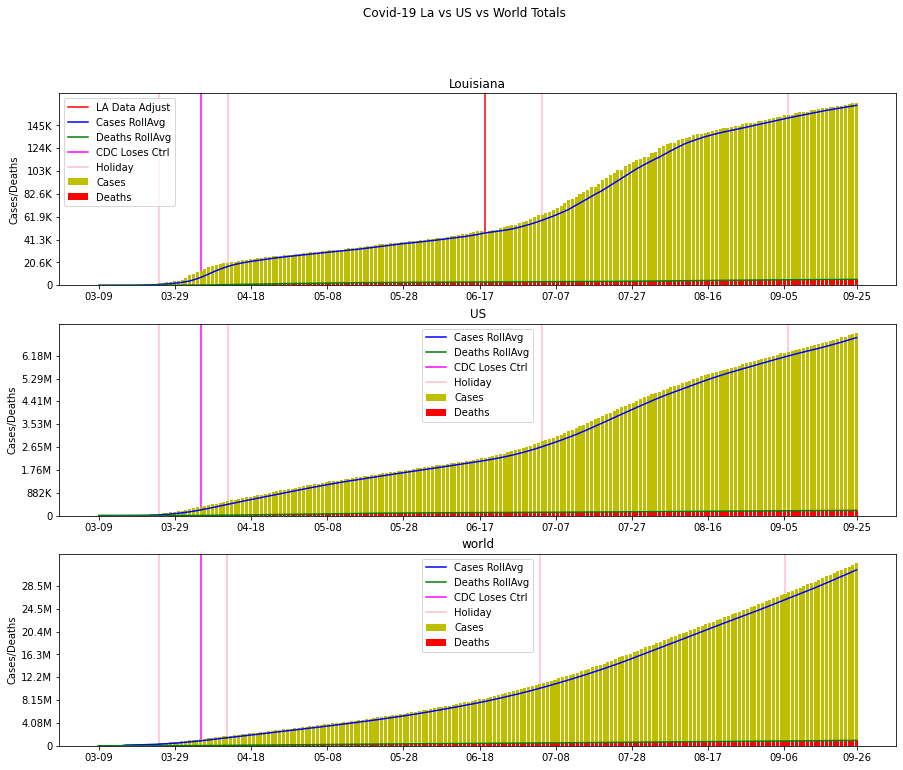

In [8]:
#Figure 2
fig, axs = plt.subplots(3, figsize=(15,12))

def plotme(df,ax, xticks):
    ax.bar(df.index,df['cases'], color='y', label='Cases')
    ax.bar(df.index,df['deaths'], color='r', label='Deaths')
    ax.plot(df.index,df['cases_ravg'], color = 'b',label='Cases RollAvg')
    ax.plot(df.index,df['deaths_ravg'], color = 'g', label='Deaths RollAvg')
    ax.set_xticks(xticks)
    ax.set_xticklabels(df.iloc[xticks,0])
    drawindexofCDCdataloss(df,ax)
    holidays(df,ax)
    ax.legend()
    

    yticks,yticklabels = getyTicks(df,'cases')
    ax.set_yticks(yticks)        
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel("Cases/Deaths")

axs[0].title.set_text('Louisiana')

#adjustments for LA data issue 4/19
LACFline(la_df,axs[0])

plotme(la_df,axs[0],la_ticks)    

axs[1].title.set_text('US')
plotme(us_df,axs[1],us_ticks)

axs[2].title.set_text("world")
plotme(world_df,axs[2],world_ticks)

fig.suptitle("Covid-19 La vs US vs World Totals")

plt.savefig("fig2.jpg")

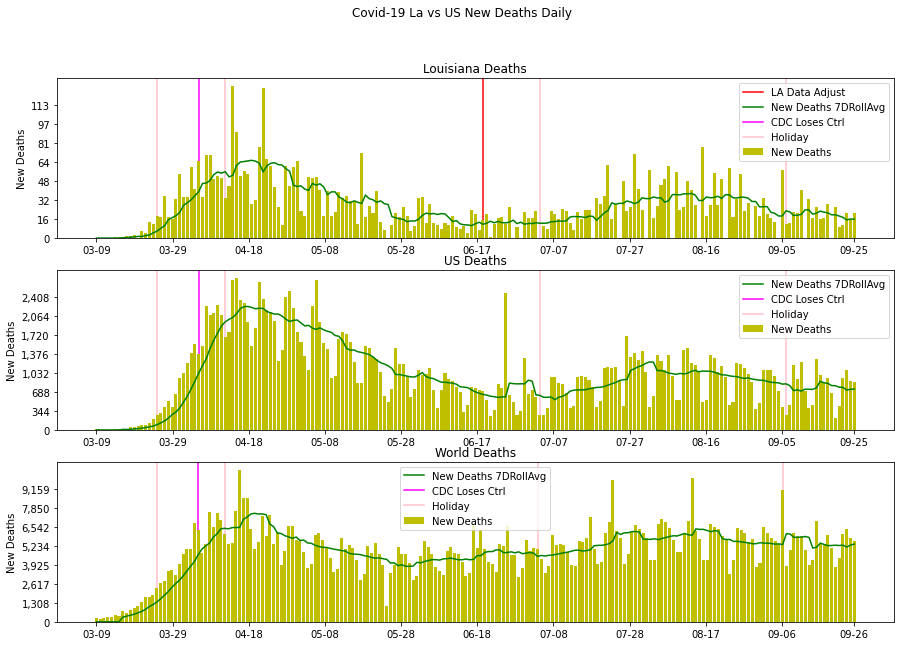

In [9]:
#Figure 3

fig, axs = plt.subplots(3, figsize=(15,10))

def plotme(df,ax,xticks):

    ax.bar(df.index,df['NewDeaths'], color = 'y', label="New Deaths")
    ax.plot(df.index,df['NewDeathsRollAvg'], color='g', label="New Deaths 7DRollAvg")
    ax.set_xticks(xticks)
    ax.set_xticklabels(df.iloc[xticks,0])
    drawindexofCDCdataloss(df,ax)
    holidays(df,ax)
    ax.legend()

    yticks,yticklabels = getyTicks(df,'NewDeaths')
    ax.set_yticks(yticks)        
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel("New Deaths")

axs[0].title.set_text('Louisiana Deaths')

#adjustments for LA data issue 4/19
LACFline(la_df,axs[0])

plotme(la_df,axs[0],la_ticks)


axs[1].title.set_text('US Deaths')
plotme(us_df,axs[1],us_ticks)

axs[2].title.set_text('World Deaths')
plotme(world_df,axs[2],world_ticks)

fig.suptitle("Covid-19 La vs US New Deaths Daily")

plt.savefig("fig3.jpg")

In [10]:
la_df_weekly = la_df.groupby('week')[['NewCases','NewDeaths']].sum()
us_df_weekly = us_df.groupby('week')[['NewCases','NewDeaths']].sum()
world_df_weekly = world_df.groupby('week')[['NewCases','NewDeaths']].sum()
us_df_weekly.tail(2)

,NewCases,NewDeaths
week,,
37,284677,5595
38,269848,4423


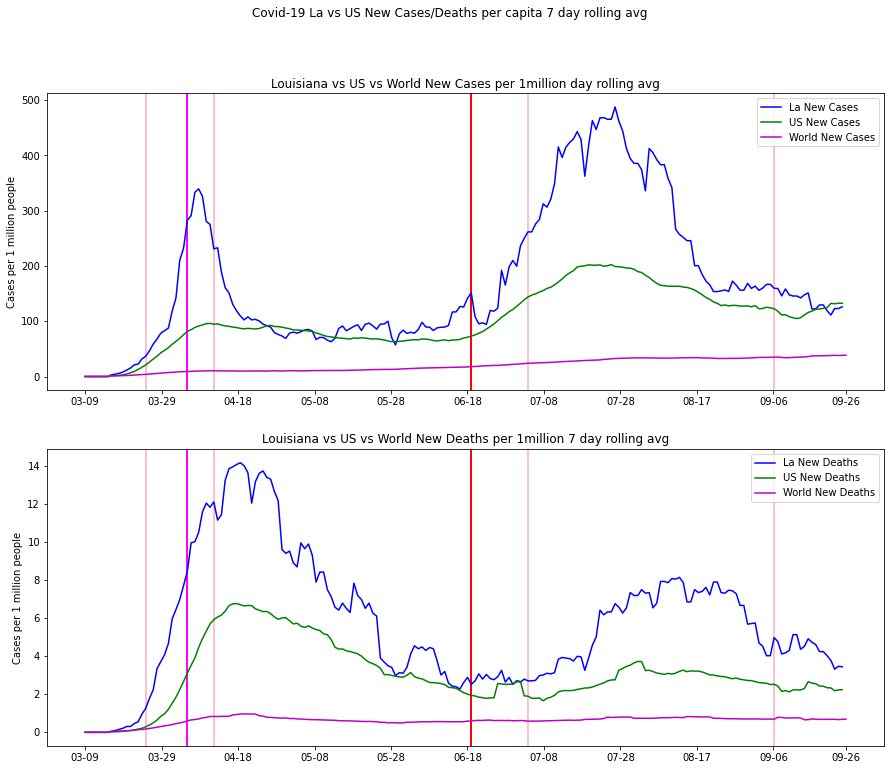

In [11]:
#Figure 4

#problem with the legend need to work on this
def plotme(df,ax,xticks, column, label, color = 'r'):
    lines = []
    
    lines.append(ax.plot(df.index,df[column],color=color, label=label))
    ax.set_xticks(xticks)
    ax.set_xticklabels(df.iloc[xticks,0])
    
    ax.set_ylabel("Cases per 1 million people")
    
    drawindexofCDCdataloss(df,ax)
    lines.append(holidays(df,ax))
    lines.append(LACFline(df,ax))   #I'm not sure the data for deaths and cases was effected by the adjustment
    
    
    
    
    return lines
    
    
fig, axs = plt.subplots(2, figsize=(15,12))

for col,ax in zip([('NewCasesPerCapita_ravg','New Cases'),('NewDeathsPerCapita_ravg', 'New Deaths')],axs):
    
    
    line1 = plotme(la_df,ax,la_ticks, col[0],"La %s" % col[1], color='b')
    
    line2 = plotme(us_df,ax,us_ticks, col[0],'US %s' % col[1], color='g')
    
    line3 = plotme(world_df,ax,world_ticks,col[0],"World %s" % col[1], color='m')
    
    ax.legend(handles=[line1[0][0],line2[0][0],line3[0][0]])
    
    
    

axs[0].title.set_text('Louisiana vs US vs World New Cases per 1million day rolling avg')
axs[1].title.set_text('Louisiana vs US vs World New Deaths per 1million 7 day rolling avg')


fig.suptitle("Covid-19 La vs US New Cases/Deaths per capita 7 day rolling avg ")

plt.savefig("fig4.jpg")

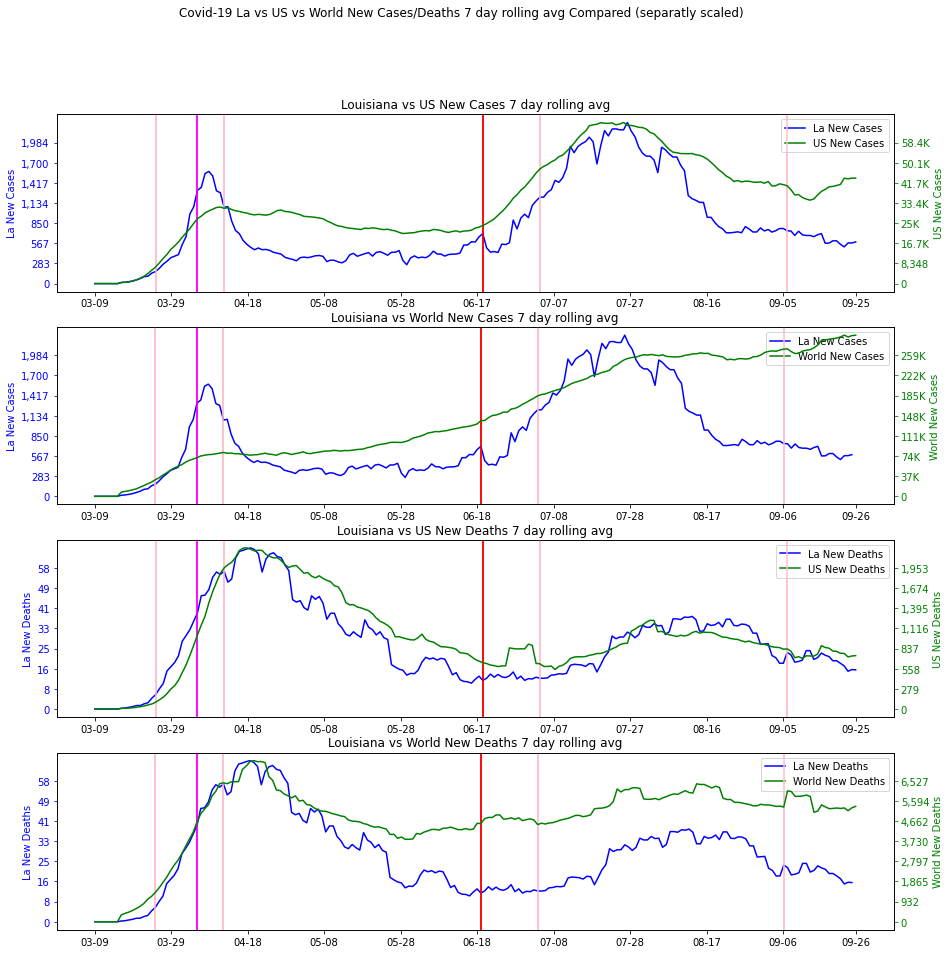

In [12]:
#Figure 5

#problem with the legend need to work on this
def plotme(df,ax,xticks, column, label, color = 'r'):
    lines = []
    
    lines.append(ax.plot(df.index,df[column],color=color, label=label))
    ax.set_xticks(xticks)
    ax.set_xticklabels(df.iloc[xticks,0])
    
    drawindexofCDCdataloss(df,ax)
    lines.append(holidays(df,ax))
    lines.append(LACFline(df,ax))   #I'm not sure the data for deaths and cases was effected by the adjustment
    
    yticks,yticklabels = getyTicks(df,column)
    ax.set_yticks(yticks)        
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel(label,color=color)
    ax.tick_params(axis='y',color=color,labelcolor=color)
    
    return lines
    
    
fig, axs = plt.subplots(4, figsize=(15,15))

idx = 0
for col, label in zip(['NewCasesRollAvg','NewDeathsRollAvg'], ['New Cases','New Deaths']):
    for compare_place, label_place in zip([(us_df,us_ticks),(world_df,world_ticks)], ['US','World']):
        line1 = plotme(la_df,axs[idx],la_ticks, col,"La %s" % label, color='b')
        axsY2 = axs[idx].twinx()
        line2 = plotme(compare_place[0],axsY2,compare_place[1], col,"%s %s" % (label_place, label), color='g')
        axs[idx].legend(handles=[line1[0][0],line2[0][0]])
        axs[idx].title.set_text("Louisiana vs %s %s 7 day rolling avg"%(label_place,label))
        idx += 1
    
fig.suptitle("Covid-19 La vs US vs World New Cases/Deaths 7 day rolling avg Compared (separatly scaled)")

plt.savefig("fig5.jpg")

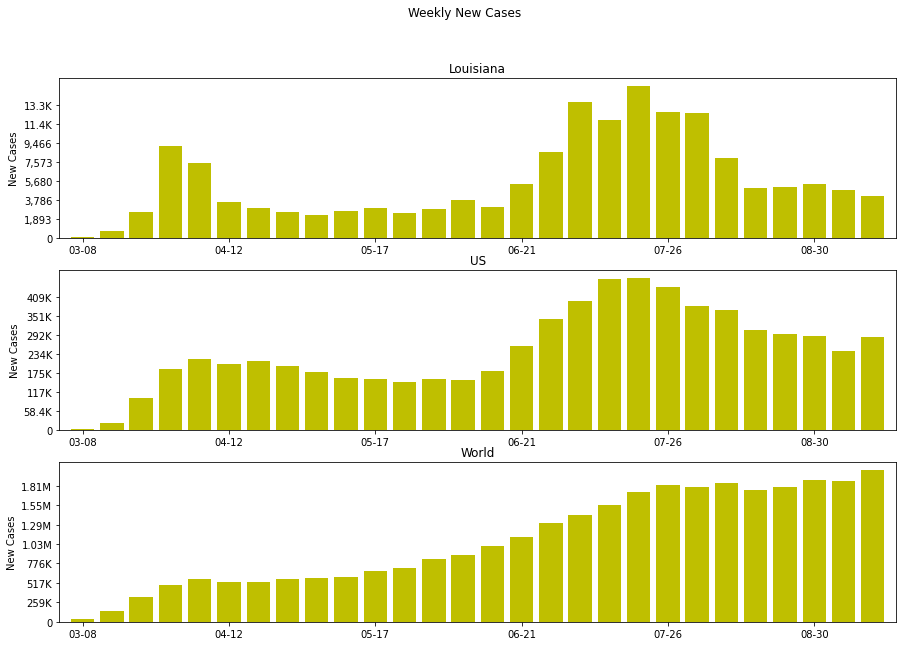

In [13]:
#Figure 6

def plotme(df,ax, title = "Graphs", color = 'y'):
    ax.bar(df.index[:-1],df['NewCases'][:-1], color=color)
    ax.set_title(title)
    #ax.set_xlabel("Week")
    
    yticks,yticklabels = getyTicks(df,'NewCases')
    ax.set_yticks(yticks)        
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel("New Cases")
    
    weeks = ax.get_xticks()
    labels = [datetime.strptime("2020-%s-0" % str(int(week)).zfill(2), "%Y-%U-%w").strftime("%m-%d") for week in weeks]
    ax.set_xticks(weeks)
    ax.set_xticklabels(labels)
    ax.set_xlim(df.index[0]-ax.patches[0].get_width(),df.index[-2]+ax.patches[0].get_width())
      
fig, axs = plt.subplots(3, figsize=(15,10))
fig.suptitle("Weekly New Cases")

plotme(la_df_weekly,axs[0], title="Louisiana")
plotme(us_df_weekly,axs[1], title="US")
plotme(world_df_weekly,axs[2],title="World")

plt.savefig("fig6.jpg")

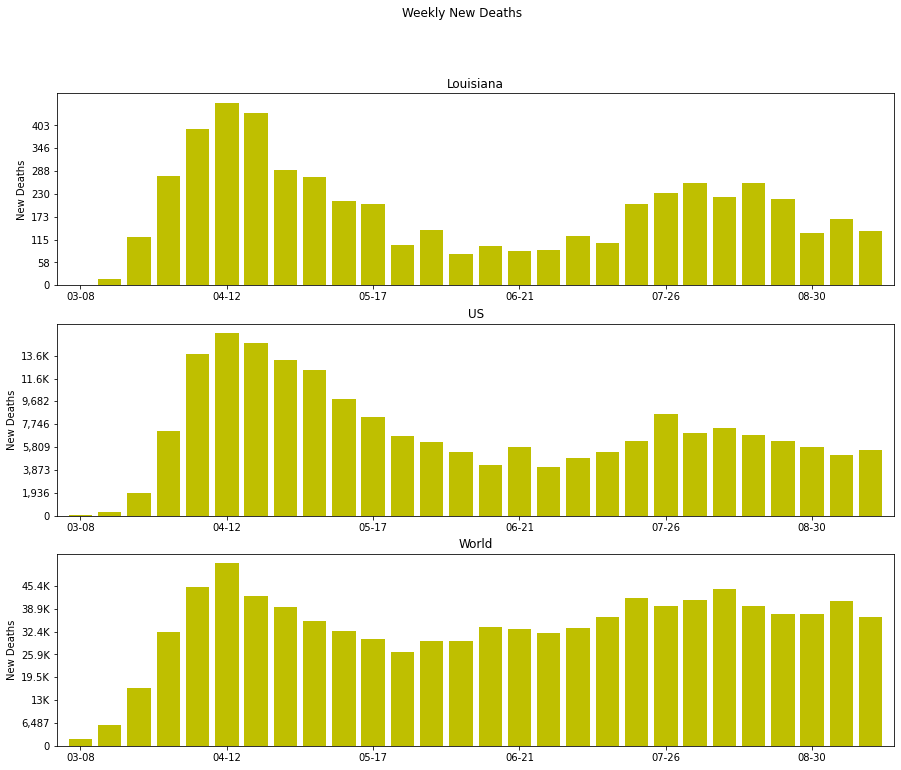

In [14]:
#Figure 7

def plotme(df,ax, title = "Graphs", color = 'y'):
    ax.bar(df.index[:-1],df['NewDeaths'][:-1], color=color)
    ax.set_title(title)
    #ax.set_xlabel("Week")
    
    yticks,yticklabels = getyTicks(df,'NewDeaths')
    ax.set_yticks(yticks)        
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel("New Deaths")
    weeks = ax.get_xticks()
    labels = [datetime.strptime("2020-%s-0" % str(int(week)).zfill(2), "%Y-%U-%w").strftime("%m-%d") for week in weeks]
    ax.set_xticks(weeks)
    ax.set_xticklabels(labels)
    ax.set_xlim(df.index[0]-ax.patches[0].get_width(),df.index[-2]+ax.patches[0].get_width())
    
    
fig, axs = plt.subplots(3, figsize=(15,12))
fig.suptitle("Weekly New Deaths")

plotme(la_df_weekly,axs[0], title="Louisiana")
plotme(us_df_weekly,axs[1], title="US")
plotme(world_df_weekly,axs[2],title="World")

plt.savefig("fig7.jpg")